<a href="https://www.kaggle.com/code/caasperart/license-plate-recognition-using-cnn?scriptVersionId=125284443" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## TR PDNN 2023
diadaptasi dari: https://github.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision

In [29]:
#  ! pip install imutils -q

import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
# import imutils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from skimage import io
import urllib.request


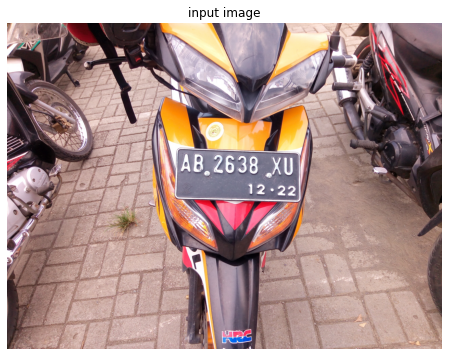

In [24]:
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()
    

# req = urllib.request.urlopen('https://awsimages.detik.net.id/customthumb/2011/05/09/648/plat-nomor-dalam.jpg')
req = urllib.request.urlopen('https://raw.githubusercontent.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision/main/test%20images/AB2638XU.jpg')
# req = urllib.request.urlopen('https://raw.githubusercontent.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision/main/test%20images/AB5592EG.jpg')
# req = urllib.request.urlopen('https://raw.githubusercontent.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision/main/test%20images/AD2914JG.jpg')


arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) # 'Load it as it is'    

# img = cv2.imread('../input/ai-indian-license-plate-recognition-data/car.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC.jpg')
display(img, 'input image')

# program untuk mendeteksi posisi plat nomor dari motor


aspect: 2.1340018231540565, 
aspect: 2.1273458445040214, 


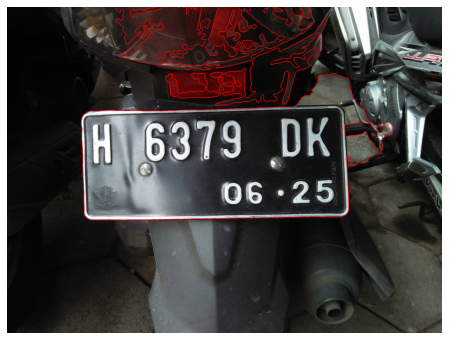

In [170]:
img = cv2.imread('/kaggle/input/haarcascadeplatenumber/IMG20230410113718.jpg')

# grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
# blured  = cv2.GaussianBlur(hisimg, (29,29), 0) 
# edged   = cv2.Canny(blured, 10, 180)
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
# dilate = cv2.dilate(edged, kernel, iterations=1)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# thresh_inv = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
thresh_inv  = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
blur = cv2.GaussianBlur(thresh_inv,(63,63),0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
edged   = cv2.Canny(thresh, 10, 180)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
dilate = cv2.dilate(thresh, kernel, iterations=1)

contours,_ = cv2.findContours(dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

image_copy = img.copy()

i=0
for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    if h>450 and w>1500 and w/h < 2.3:
        print(f'aspect: {w/h}, ')
        cv2.drawContours(image_copy, contours, i, (0,0,255), 4)
    i+=1

# plt.imshow(thresh)
display(image_copy)

In [243]:
indeximg=0
filepath=[]
for root, dirname, filename in os.walk('/kaggle/input/haarcascadeplatenumber'):
    for file in filename:
        filepath.append(os.path.join(root, file))

aspect ratio from index: 2021, 2.464114832535885, w: 2575, h: 1045
detected plat no: 1, index: 64


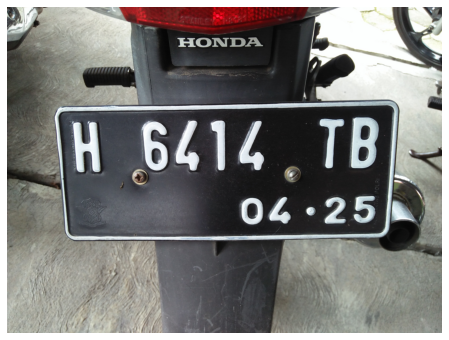

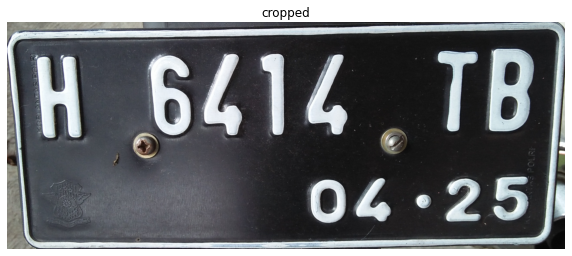

In [410]:
img = cv2.imread(filepath[indeximg])

grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
blured  = cv2.GaussianBlur(hisimg, (21,21), 0) 
edged   = cv2.Canny(blured, 10, 180)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
dilate = cv2.dilate(edged, kernel, iterations=1)

contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_copy = img.copy()
cv2.drawContours(image_copy, contours, -1, (0, 0, 255), 2)

platno=[]
index=0

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = w/h

    if w > 560 and h>350 and h<1100 and aspect_ratio > 1.6 and aspect_ratio<=2.6: 
        print(f'aspect ratio from index: {index}, {aspect_ratio}, w: {w}, h: {h}')        
        platno.append(index)
    index += 1
print(f'detected plat no: {len(platno)}, index: {indeximg}')

# plt.imshow(img)
display(img)
# display(dilate)
# display(image_copy)

if len(platno) >0:
    indexplatno = platno[0]
    detectedimg = img.copy()
    x,y,w,h = cv2.boundingRect(contours[indexplatno])
    croppedimg = img[y: y+h, x:x+w]
    display(croppedimg, "cropped")
    
# increment indeximg
indeximg +=1

In [349]:
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC2.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/IMG20230410113606.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/IMG20230410113827.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/IMG20230410113833.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/IMG20230410113613.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/IMG20230410084106.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/IMG20230410084035.jpg')

# req = urllib.request.urlopen('https://t-2.tstatic.net/gorontalo/foto/bank/images/12102022_plat-nomor-putih.jpg')

# req = urllib.request.urlopen('https://image.cermati.com/q_70,w_1200,h_800,c_fit/cgbt1mggrzxkk5p5xtot')
# arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
# img = cv2.imdecode(arr, -1) # 'Load it as it is'    


grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
blured  = cv2.GaussianBlur(hisimg, (23,23), 0) 
edged   = cv2.Canny(blured, 10, 180)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
dilate = cv2.dilate(edged, kernel, iterations=1)

contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_copy = img.copy()
cv2.drawContours(image_copy, contours, -1, (0, 0, 255), 2)


image_copy = img.copy()
cv2.drawContours(image_copy, contours, -1, (0, 0, 255), 2)

platno=[]
index=0
sx = sy = sw = sh =[]

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = w/h

    if w > 500 and h>350 and h<1100 and aspect_ratio <= 3 and aspect_ratio > 1.6 and aspect_ratio<=2.6: 
        print(f'aspect ratio from index: {index}, {aspect_ratio}, w: {w}, h: {h}')        
        platno.append(index)
    index += 1
print(f'detected plat no: {len(platno)}')

if len(platno) <=2:
    indexplatno = platno[0]
    detectedimg = img.copy()
    x,y,w,h = cv2.boundingRect(contours[indexplatno])
#     cv2.drawContours(detectedimg, contours, indexplatno, (0, 0, 255), 5)
    croppedimg = img[y: y+h, x:x+w]
    display(croppedimg, "cropped")

    
for p in platno:
    x,y,w,h = cv2.boundingRect(contours[indexplatno])
    cv2.rectangle(detectedimg, (x,y), (x+w, y+h), (0,0,255), 3)

print(indexplatno)

plt.imshow(img)

# display(hisimg, "contour")
# display(thresh, "edged")
# display(dilate, "position")
display(detectedimg, "position")
# display(image_copy, "dilated")
# display(croppedimg, "cropped")



detected plat no: 0


IndexError: list index out of range

# program untuk mendeteksi digit dari plat nomor motor

x: 140, y: 160, w: 203, h: 372
x: 1375, y: 156, w: 126, h: 278
x: 126, y: 150, w: 219, h: 384
x: 646, y: 149, w: 203, h: 373
x: 1389, y: 147, w: 183, h: 372
x: 1168, y: 145, w: 112, h: 376
x: 908, y: 145, w: 178, h: 377
x: 1988, y: 134, w: 184, h: 369
x: 1986, y: 131, w: 188, h: 374
x: 2225, y: 124, w: 206, h: 378
x: 2223, y: 121, w: 210, h: 383
detected candidate plat no: 11
[754, 755, 758, 759, 763, 765, 766, 779]


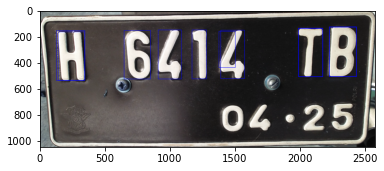

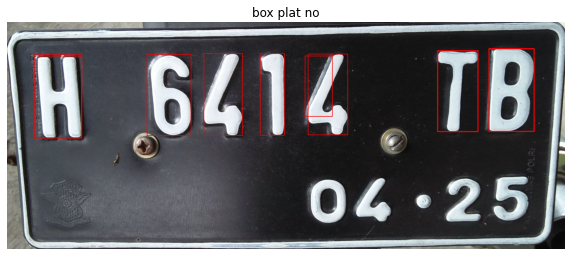

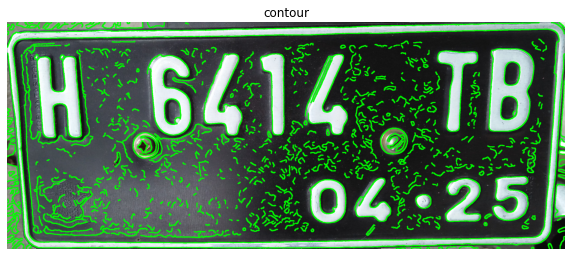

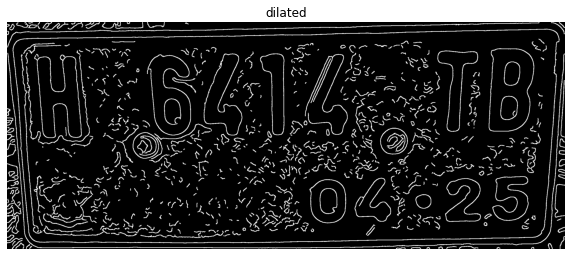

[783, 779, 797, 790]
[758, 754, 759, 766, 765, 755, 763, 783, 779, 797, 790]


In [412]:
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC2.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC1.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6498SI.jpg')

# req = urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/a/a5/Plat_Nomor_Nganjuk_%283_Huruf%29.jpg')
# arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
# img = cv2.imdecode(arr, -1)

"""
grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
blured  = cv2.GaussianBlur(hisimg, (29,29), 0) 
edged   = cv2.Canny(blured, 10, 180)


kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
dilate = cv2.dilate(edged, kernel, iterations=1)
"""

grayimg = cv2.cvtColor(croppedimg, cv2.COLOR_BGR2GRAY)
hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
blured  = cv2.GaussianBlur(hisimg, (29,29), 0) 
edged   = cv2.Canny(blured, 10, 120)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
dilate = cv2.dilate(edged, kernel, iterations=1)

contours, _ = cv2.findContours(dilate, cv2.RETR_LIST , cv2.CHAIN_APPROX_SIMPLE)
image_copy = croppedimg.copy()
imgrec = croppedimg.copy()

platno=[]
index=0
realPlatno=0
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = w/h
    luas = w*h
#     print(f'aspect ratio from index: {index}, aspectRatio: {aspect_ratio}, w: {w}, h: {h}')
    if w > 110 and h>=120 and h <410 and aspect_ratio <= 0.7 :
        platno.append(index)
        cv2.drawContours(image_copy, contours, index, (0, 255, 0), 2)
        print(f'x: {x}, y: {y}, w: {w}, h: {h}')
        cv2.rectangle(imgrec, (x,y), (x+w,y+h), (0,0,255),2)
        realPlatno+=1
    index += 1
print(f'detected candidate plat no: {len(platno)}')

for a in platno:
    xa,ya,wa,ha = cv2.boundingRect(contours[a])
#     print("=========================")
    for b in platno:
        if a == b:
            continue
        else:
            xb,yb,wb,hb = cv2.boundingRect(contours[b])
            ydif = ya-yb
            xdif = xa-xb
            wdif = wa-wb
            hdif = ha-hb
#             print(f'ydif: {ydif}, xdif: {xdif}, wdif: {wdif}, hdif: {hdif}')
            
counter=0
score=np.zeros(len(platno))
for a in platno:
    xa, ya, wa, ha = cv2.boundingRect(contours[a])
#     print("============================")
    for b in platno:
        if a == b :
            continue
        else:
            xb, yb, wb, hb = cv2.boundingRect(contours[b])
            ydif = ya-yb
#             print(f'ya: {ya}, yb: {yb}, ydif: {ydif}')
            
            if ydif<11:
                score[counter] = score[counter]+1
            
    counter += 1

indexRealChar=[]
charCounter=0
for sc in score:
    if sc != max(score):
        indexRealChar.append(platno[charCounter])
        
    charCounter+=1
    
print(indexRealChar)
finalimg = croppedimg.copy()
for char in indexRealChar:
    x,y,w,h = cv2.boundingRect(contours[char])
    cv2.rectangle(finalimg, (x,y), (x+w,y+h), (150,0,0),2)

cv2.drawContours(image_copy, contours, -1, (0, 255, 0), 2)    
plt.imshow(imgrec)

display(imgrec, "box plat no")
# display(hisimg, "detected plat no")
# display(blured, "detected plat no")
display(image_copy, "contour")
# display(edged, "edged")
display(dilate, "dilated")

urutx = []
for char in platno:
    x,y,w,h = cv2.boundingRect(contours[char])
    urutx.append(x)
urutx = sorted(urutx)

## urutkan karakter plat nomor dari kiri ke kanan
cropCharUrut=[]
for ux in urutx:
    for char in platno :
        x,y,w,h = cv2.boundingRect(contours[char])
        if x == ux: 
            cropCharUrut.append(char)
            break
            
poped = []
for c in cropCharUrut:
    x,y,w,h = cv2.boundingRect(contours[c])
    for i in cropCharUrut:
        if c==i:
            continue
        x2,y2,w2,h2 = cv2.boundingRect(contours[i])
        
        if abs(x-x2) < 10:
            poped.append(c)
            break
            
print(poped)

print(cropCharUrut)


# **Selanjutnya buat program untuk ekstract setiap digit dari plat nomor dan melakukan klasifikasi karakter yang didapatkan**

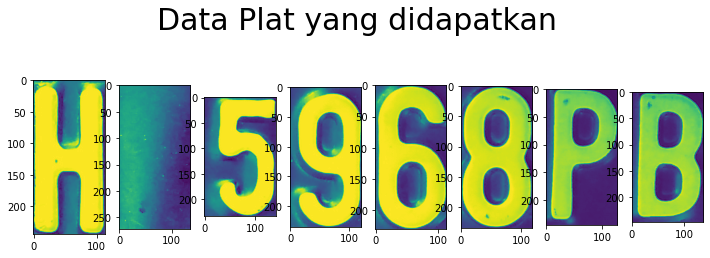

In [406]:
# tampilkan karakter yang telah terpotong
imgs=[]
for char in cropCharUrut:
    x,y,w,h = cv2.boundingRect(contours[char])
    crop = grayimg[y: y+h, x:x+w]
    imgs.append(crop)

# buat 1 plot dan tampilkan 
_, axs = plt.subplots(1, len(cropCharUrut), figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.figtext(.5,.65,'Data Plat yang didapatkan',fontsize=30,ha='center')
plt.show()

# Buat Model Untuk Klasifikasi 
## **Nek meh ubah" / edit, nggawe Cell dewe, trus jenengi, ngen ra bingung**

In [8]:
"""
Cell nggone AH... Ojo diubah ubah
Buat Model dari tutorial:
https://www.tensorflow.org/tutorials/images/classification
"""

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

path = '/kaggle/input/dataset-characters-indo-plate/dataset_characters'

batchSize = 32
imgHeight = 40
imgWidth  = 40

trainDs = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split = 0.2,
    subset="training",
    seed=123,
    image_size=(imgHeight, imgWidth),
    batch_size = batchSize )

valDs = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(imgHeight, imgWidth),
    batch_size=batchSize )

className = trainDs.class_names
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = trainDs.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = valDs.cache().prefetch(buffer_size=AUTOTUNE)

numClass = len(className)

# buat model dengan tensorflow sequential
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(imgHeight, imgWidth, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(numClass)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'] )

model.summary()

Found 36041 files belonging to 36 classes.
Using 28833 files for training.
Found 36041 files belonging to 36 classes.
Using 7208 files for validation.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 40, 40, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 40, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1

In [9]:
epochs=10
history = model.fit(trainDs,
                    validation_data = valDs,
                    epochs=epochs)

Epoch 1/10
902/902 [==============================] - 136s 151ms/step - loss: 0.5330 - accuracy: 0.8594 - val_loss: 0.2871 - val_accuracy: 0.9222
Epoch 2/10
902/902 [==============================] - 68s 76ms/step - loss: 0.1812 - accuracy: 0.9504 - val_loss: 0.2426 - val_accuracy: 0.9284
Epoch 3/10
902/902 [==============================] - 66s 73ms/step - loss: 0.1152 - accuracy: 0.9673 - val_loss: 0.1708 - val_accuracy: 0.9523
Epoch 4/10
902/902 [==============================] - 66s 73ms/step - loss: 0.0819 - accuracy: 0.9768 - val_loss: 0.1607 - val_accuracy: 0.9567
Epoch 5/10
902/902 [==============================] - 67s 74ms/step - loss: 0.0625 - accuracy: 0.9817 - val_loss: 0.1537 - val_accuracy: 0.9570
Epoch 6/10
902/902 [==============================] - 65s 72ms/step - loss: 0.0522 - accuracy: 0.9861 - val_loss: 0.1492 - val_accuracy: 0.9600
Epoch 7/10
902/902 [==============================] - 64s 70ms/step - loss: 0.0434 - accuracy: 0.9879 - val_loss: 0.1408 - val_accurac

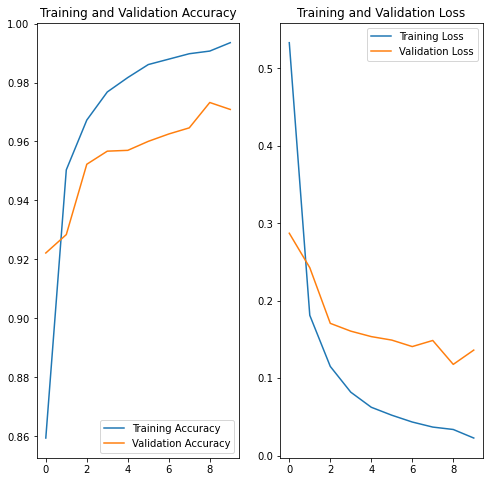

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

model.save('my_model') # Save trained model

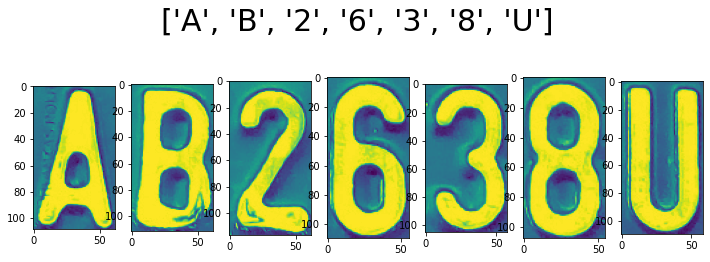

In [11]:
model = keras.models.load_model('/kaggle/working/my_model')

# display(imgs[index])
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
predictedPlat=[]


for index in range(0, len(imgs)):
    image =cv2.adaptiveThreshold(np.array(imgs[index]), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
    char_crop = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # resize citra karakternya
    char_crop = cv2.resize(char_crop, (imgWidth, imgHeight))
#     display(char_crop)

    # preprocessing citra ke numpy array
    img_array = keras.preprocessing.image.img_to_array(char_crop)
    # agar shape menjadi [1, h, w, channels]
    img_array = tf.expand_dims(img_array, 0)

    pred = model.predict(img_array)
    score = tf.nn.softmax(pred[0])

#     print(class_names[np.argmax(score)])
#     ax.imshow(image)
    predictedPlat.append(class_names[np.argmax(score)])
    
_, axs = plt.subplots(1, len(cropCharUrut), figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.figtext(.5,.65,predictedPlat,fontsize=30,ha='center')
plt.show()

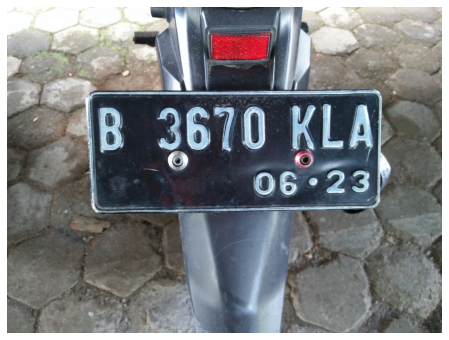

In [28]:


for dirpath, dirname, filename in os.walk('/kaggle/input/haarcascadeplatenumber/'):
    for file in filename:
#         print(file)
        print(os.sep.join([dirpath, file]))


